In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score
import matplotlib.pyplot as plt


In [2]:
final_cols_unbanked = [
    "FLAG_OWN_CAR",
    "NAME_EDUCATION_TYPE",
    "DAYS_EMPLOYED",
    "CODE_GENDER",
    "DAYS_BIRTH",
    "AMT_CREDIT",
    "NAME_INCOME_TYPE",
    "NAME_FAMILY_STATUS",
    "OCCUPATION_TYPE",
    "AMT_INCOME_TOTAL",
    "NAME_HOUSING_TYPE",
    "FLAG_OWN_REALTY",
    "CNT_CHILDREN",
]

final_cols_unbanked_refined = [
    "FLAG_OWN_CAR",
    "NAME_EDUCATION_TYPE",
    "DAYS_EMPLOYED",
    "REG_CITY_NOT_LIVE_CITY",
    "AMT_GOODS_PRICE",
    "REG_CITY_NOT_WORK_CITY",
    "DAYS_BIRTH",
    "AMT_CREDIT",
    "NAME_INCOME_TYPE",
    "NAME_FAMILY_STATUS",
    "OCCUPATION_TYPE",
    "AMT_INCOME_TOTAL",
    "NAME_HOUSING_TYPE",
    "FLAG_OWN_REALTY",
    "CNT_CHILDREN",
]


In [3]:
df = pd.read_csv("./data/application_train.csv")
## clean up some rows
df["DAYS_EMPLOYED"][df["DAYS_EMPLOYED"] == 365243] = np.nan
df["OBS_30_CNT_SOCIAL_CIRCLE"][df["OBS_30_CNT_SOCIAL_CIRCLE"] > 30] == np.nan
df["OBS_60_CNT_SOCIAL_CIRCLE"][df["OBS_60_CNT_SOCIAL_CIRCLE"] > 30] == np.nan
df = df[df["CODE_GENDER"] != "XNA"]
df["DAYS_BIRTH"] = df["DAYS_BIRTH"] * -1 / 365
categorical_columns = df.dtypes[df.dtypes == "object"].index.tolist()
df[categorical_columns] = df[categorical_columns].fillna("XNA")
df["REGION_RATING_CLIENT"] = df["REGION_RATING_CLIENT"].astype("object")
df["REGION_RATING_CLIENT_W_CITY"] = df["REGION_RATING_CLIENT_W_CITY"].astype("object")

## remove rows with only 1 distinct value
empty_columns = []
for col in df.columns:
    if len(df[col].unique()) <= 1:
        empty_columns.append(col)
df = df.drop(empty_columns, axis=1)

# shitty self made encoder
encoder_dict = {}
for col in list(df.columns):
    if str(df[col].dtypes) == "object":
        tmp = list(df[col].unique())
        encoder = {name: i for i, name in enumerate(tmp)}
        encoder_dict[col] = encoder
        df[col] = df[col].apply(lambda x: encoder[x])

target_df = df.pop("TARGET")

<ipython-input-3-ea7e96bd0c23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DAYS_EMPLOYED"][df["DAYS_EMPLOYED"] == 365243] = np.nan


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df[final_cols_unbanked], target_df, test_size=0.2
)

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)


In [17]:
## Hyper param tuning
def xgb_eval(
    max_depth,
    min_child_weight,
    gamma,
    subsample,
    colsample_bytree,
    colsample_bylevel,
    colsample_bynode,
    reg_alpha,
    reg_lambda,
):
    params = {
        "objective": "reg:logistic",
        "learning_rate": 0.01,
        # "n_estimators": 10000,
        "max_depth": int(round(max_depth)),
        "min_child_weight": int(round(min_child_weight)),
        "subsample": subsample,
        "gamma": gamma,
        "colsample_bytree": colsample_bytree,
        "colsample_bylevel": colsample_bylevel,
        "colsample_bynode": colsample_bynode,
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "random_state": 69,
    }
    bst = xgb.train(params, dtrain, num_boost_round=5, verbose_eval=False)
    y_pred = bst.predict(dtest)
    return roc_auc_score(y_test, y_pred)


bopt_xgb = BayesianOptimization(
    xgb_eval,
    {
        "max_depth": (5, 15),
        "min_child_weight": (5, 80),
        "gamma": (0.2, 1),
        "subsample": (0.5, 1),
        "colsample_bytree": (0.5, 1),
        "colsample_bylevel": (0.3, 1),
        "colsample_bynode": (0.3, 1),
        "reg_alpha": (0.001, 0.3),
        "reg_lambda": (0.001, 0.3),
    },
    random_state=69,
)
bopt_xgb.maximize(n_iter=6, init_points=4)


|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.647    |  0.5074   |  0.8663   |  0.6751   |  0.8315   |  10.61    |  24.02    |  0.03239  |  0.01848  |  0.8366   |
|  2        |  0.6512   |  0.7885   |  0.8129   |  0.8939   |  0.2611   |  8.177    |  60.58    |  0.09922  |  0.1416   |  0.5905   |
|  3        |  0.6429   |  0.5265   |  0.6184   |  0.7648   |  0.4344   |  7.77     |  55.86    |  0.0708   |  0.2035   |  0.7162   |
|  4        |  0.6396   |  0.5714   |  0.5348   |  0.7566   |  0.9902   |  10.31    |  56.03    |  0.1179   |  0.03585  |  0.8536   |
|  5        |  0.6529   |  0.8364   |  0.8233   |  0.8697   |  0.2      |  7.453    |  62.32    |  0.1725   |  0.1443   |  0.5004   |
|  6        |  0.6504   |  0.3323   |  1.0      |  1.0      | 

In [18]:
## best params
params = bopt_xgb.max['params']
## convert params to int
for k in ["max_depth", 'min_child_weight']:
    params[k] = int(params[k])

## basic logistic reg
xg_reg = xgb.XGBRegressor(objective="reg:logistic", **params)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")
accuracy = accuracy_score(y_test, [round(i) for i in y_pred])
print(f"Accuracy: {accuracy}")

RMSE: 0.2691528979131619
Accuracy: 0.9193034372865923


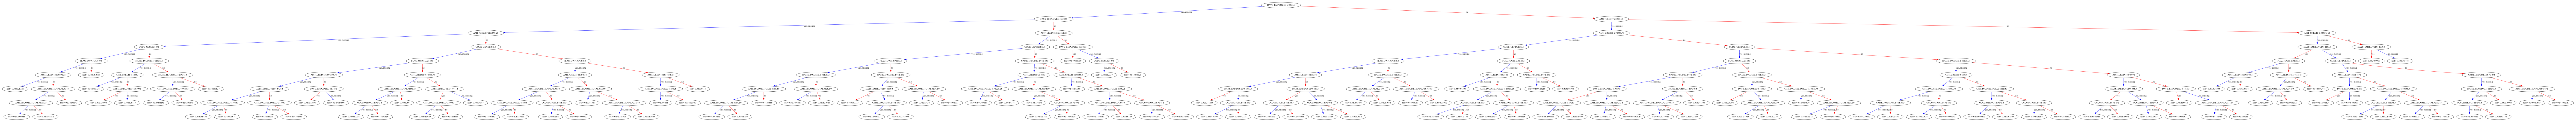

In [7]:
## get score card
xgb.plot_tree(xg_reg)
plt.gcf().set_size_inches(200, 200)
plt.savefig("scorecard.pdf")